In [2]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp
import scFates as scf
import decoupler as dc

import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Figures aesthetics
sc.set_figure_params(dpi=150)
sns.set_style("ticks")
scv.settings.verbosity = 0

In [65]:
clones = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/merged_clones_trunk_E13/E13_clonal_embedding.h5ad")
clones = clones[~clones.obs["leiden_0.5"].isin(["2", "6", "7"])].copy()

adata = sc.read_h5ad("/home/sergey/data/clonal_project/anndatas/merged_clones_trunk_E13/trunk_mes_E13_clonal_clusters.h5ad")
adata = sl.pp.prepare_multiple_injections(
    adata,
    injection_cols=["E7.5:clones", "E8.5:clones"],
)
adata.obs["clone"] = [i.replace("clones_", "") for i in adata.obs.clone]
adata = adata[adata.obs.clone.isin(clones.obs_names)].copy()
sc.pp.filter_genes(adata, min_cells=200)

clones = clones[clones.obs_names.isin(adata.obs.clone)]
clone_to_batch = dict(adata.obs[["clone", "batch"]].values)
clones.obs["batch"] = [clone_to_batch[i] for i in clones.obs_names]

adata.layers["scaled"] = sc.pp.scale(adata.X, copy=True)

In [6]:
sc.settings.figdir = "figures_CatBoost"

In [8]:
fig, ax = plt.subplots(figsize=(3, 4))
sc.pl.umap(clones, color="batch", groups=["injection3", "injection4", "injection7"],
           ax=ax, show=False, frameon=False, na_in_legend=False, title="Validation clones",
           save="validation.pdf")

<Axes: title={'center': 'Validation clones'}, xlabel='UMAP1', ylabel='UMAP2'>

In [9]:
fig, ax = plt.subplots(figsize=(3, 4))
sc.pl.umap(clones, color="batch", groups=["injection5", "injection6", "injection2"],
           ax=ax, show=False, frameon=False, na_in_legend=False, title="Train clones",
           save="Train.pdf")

<Axes: title={'center': 'Train clones'}, xlabel='UMAP1', ylabel='UMAP2'>

In [7]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="clone",
    groups_col="celltype_l2",
    mode="mean",
    min_cells=0,
    min_counts=0,
)
pdata.obsm["clone2vec"] = clones[pdata.obs.clone.values].obsm["word2vec"].copy()

pdata_validation = pdata[pdata.obs.batch.isin(["injection3", "injection4", "injection7"])]
pdata_train = pdata[~pdata.obs.batch.isin(["injection3", "injection4", "injection7"])]

In [65]:
pdata_train.to_df().to_csv("catboost_data/GEX_train.csv")
pd.DataFrame(
    pdata_train.obsm["clone2vec"],
    index=pdata_train.obs_names,
    columns=[f"clone2vec_{i}" for i in range(1, 11)],
).to_csv("catboost_data/clone2vec_train.csv")

pdata_validation.to_df().to_csv("catboost_data/GEX_validation.csv")
pd.DataFrame(
    pdata_validation.obsm["clone2vec"],
    index=pdata_validation.obs_names,
    columns=[f"clone2vec_{i}" for i in range(1, 11)],
).to_csv("catboost_data/clone2vec_validation.csv")

pd.concat([pdata_train.to_df(), pdata_train.obs["celltype_l2"]], axis=1).to_csv("catboost_data/GEX_ct_train.csv")
pd.concat([pdata_validation.to_df(), pdata_validation.obs["celltype_l2"]], axis=1).to_csv("catboost_data/GEX_ct_validation.csv")

pd.get_dummies(
    pd.concat([pdata_train.to_df(), pdata_train.obs["celltype_l2"]], axis=1)
).to_csv("catboost_data/GEX_dummy_ct_train.csv")
pd.get_dummies(
    pd.concat([pdata_validation.to_df(), pdata_validation.obs["celltype_l2"]], axis=1)
).to_csv("catboost_data/GEX_dummy_ct_validation.csv")

## General model

The following scripts will be launched on a HPC:

1. **Model without cell type information**
```python
#!/usr/bin/python3

import pandas as pd
from catboost import Pool, CatBoostRegressor

X_train = pd.read_csv("GEX_train.csv", index_col=0)
y_train = pd.read_csv("clone2vec_train.csv", index_col=0)
train = Pool(data=X_train, label=y_train)

X_validation = pd.read_csv("GEX_validation.csv", index_col=0)
y_validation = pd.read_csv("clone2vec_validation.csv", index_col=0)
validation = Pool(data=X_validation, label=y_validation)

model = CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    num_trees=10000,
    early_stopping_rounds=100,
)

model.fit(
    train,
    eval_set=validation,
    use_best_model=True,
)

model.save_model("GEX_to_clone2vec.CatBoostRegressor")
```

2. **Model with cell type information** (native CatBoost cell type parsing)
```python
#!/usr/bin/python3

import pandas as pd
from catboost import Pool, CatBoostRegressor

X_train = pd.read_csv("GEX_ct_train.csv", index_col=0)
y_train = pd.read_csv("clone2vec_train.csv", index_col=0)
train = Pool(data=X_train, label=y_train, cat_features=["celltype_l2"])

X_validation = pd.read_csv("GEX_ct_validation.csv", index_col=0)
y_validation = pd.read_csv("clone2vec_validation.csv", index_col=0)
validation = Pool(data=X_validation, label=y_validation, cat_features=["celltype_l2"])

model = CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    num_trees=10000,
    early_stopping_rounds=100,
)

model.fit(
    train,
    eval_set=validation,
    use_best_model=True,
)

model.save_model("GEX_celltype_to_clone2vec.CatBoostRegressor")
```

3. **Model with cell type information** (cell type as dummy variables)

```python
#!/usr/bin/python3
import pandas as pd
from catboost import Pool, CatBoostRegressor

X_train = pd.read_csv("GEX_dummy_ct_train.csv", index_col=0)
y_train = pd.read_csv("clone2vec_train.csv", index_col=0)
train = Pool(data=X_train, label=y_train)

X_validation = pd.read_csv("GEX_dummy_ct_validation.csv", index_col=0)
y_validation = pd.read_csv("clone2vec_validation.csv", index_col=0)
validation = Pool(data=X_validation, label=y_validation)

model = CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    num_trees=10000,
    early_stopping_rounds=100,
)

model.fit(
    train,
    eval_set=validation,
    use_best_model=True,
)

model.save_model("GEX_dummy_celltype_to_clone2vec.CatBoostRegressor")
```

In [11]:
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor()
model.load_model("catboost_models/with_validation/GEX_celltype_to_clone2vec.CatBoostRegressor")

In [12]:
shap_values_raw = model.get_feature_importance(
    data=Pool(
        data=pd.concat([pdata.to_df(), pdata.obs.celltype_l2], axis=1),
        label=pdata.obsm["clone2vec"],
        cat_features=["celltype_l2"],
    ),
    type="ShapValues",
)

shap_values = pd.DataFrame(
    np.linalg.norm(shap_values_raw, axis=1)[:, :-1],
    columns=list(pdata.var_names) + ["Cell type"],
    index=pdata.obs_names,
)

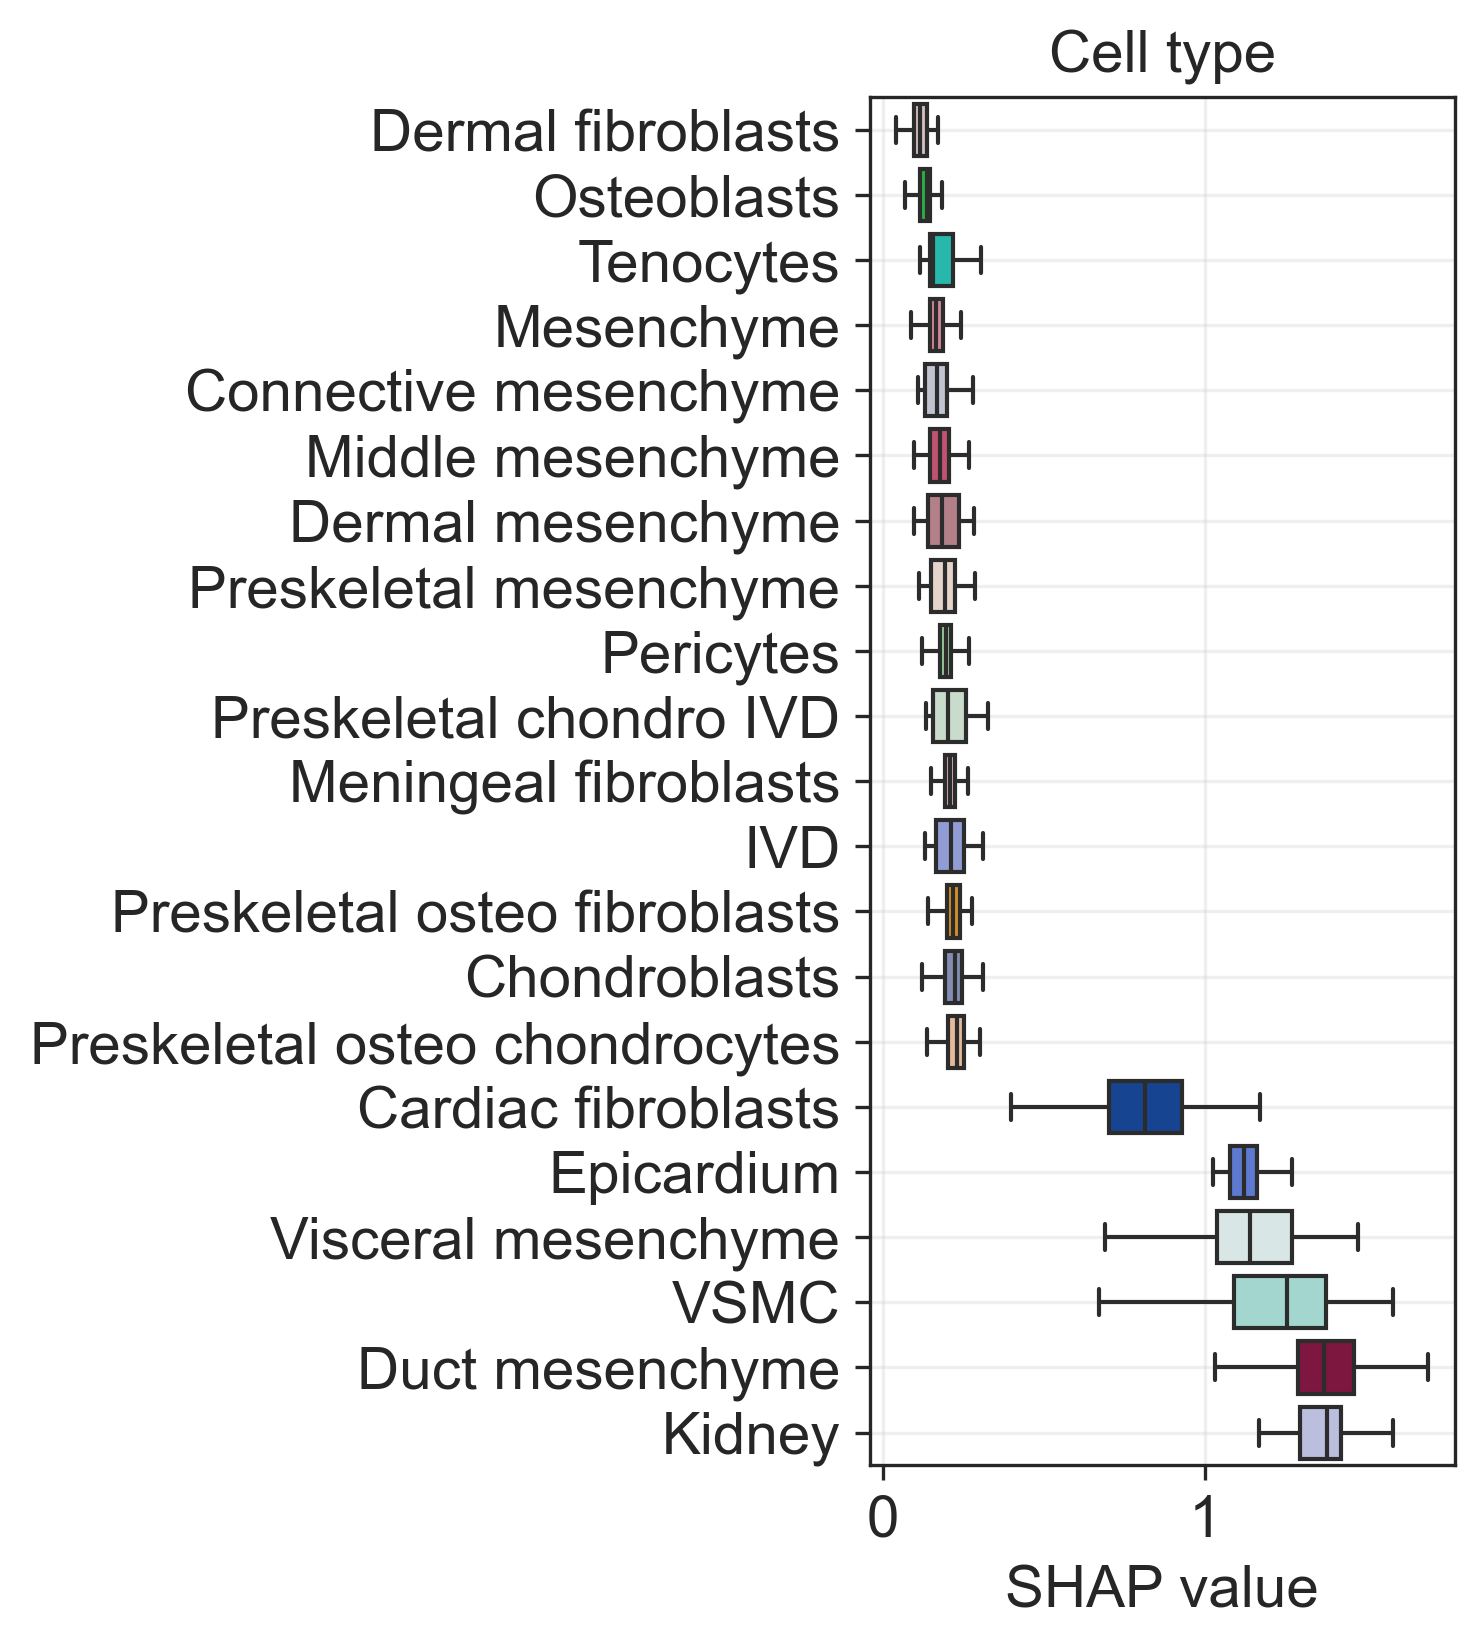

In [16]:
gene = "Cell type"
order = shap_values[gene].groupby(pdata.obs.celltype_l2).median().sort_values().index

fig, ax = plt.subplots(figsize=(2.5, 6))
sns.boxplot(
    y=pdata.obs.celltype_l2,
    x=shap_values[gene],
    showfliers=False,
    ax=ax,
    palette=dict(zip(
        adata.obs.celltype_l2.cat.categories,
        adata.uns["celltype_l2_colors"],
    )),
    order=order,
)
ax.grid(alpha=0.3)
ax.set_xlabel("SHAP value")
ax.set_ylabel("")
ax.set_title(gene)

plt.savefig("figures_CatBoost/celltype_SHAP.pdf", bbox_inches="tight")

In [17]:
shapdata = sc.AnnData(shap_values, obs=pdata.obs)

shapdata.var["mean_SHAP"] = shapdata.X.mean(axis=0)
for ct in set(shapdata.obs.celltype_l2):
    shapdata.var[f"mean_SHAP_{ct}"] = shapdata[shapdata.obs.celltype_l2 == ct].X.mean(axis=0)

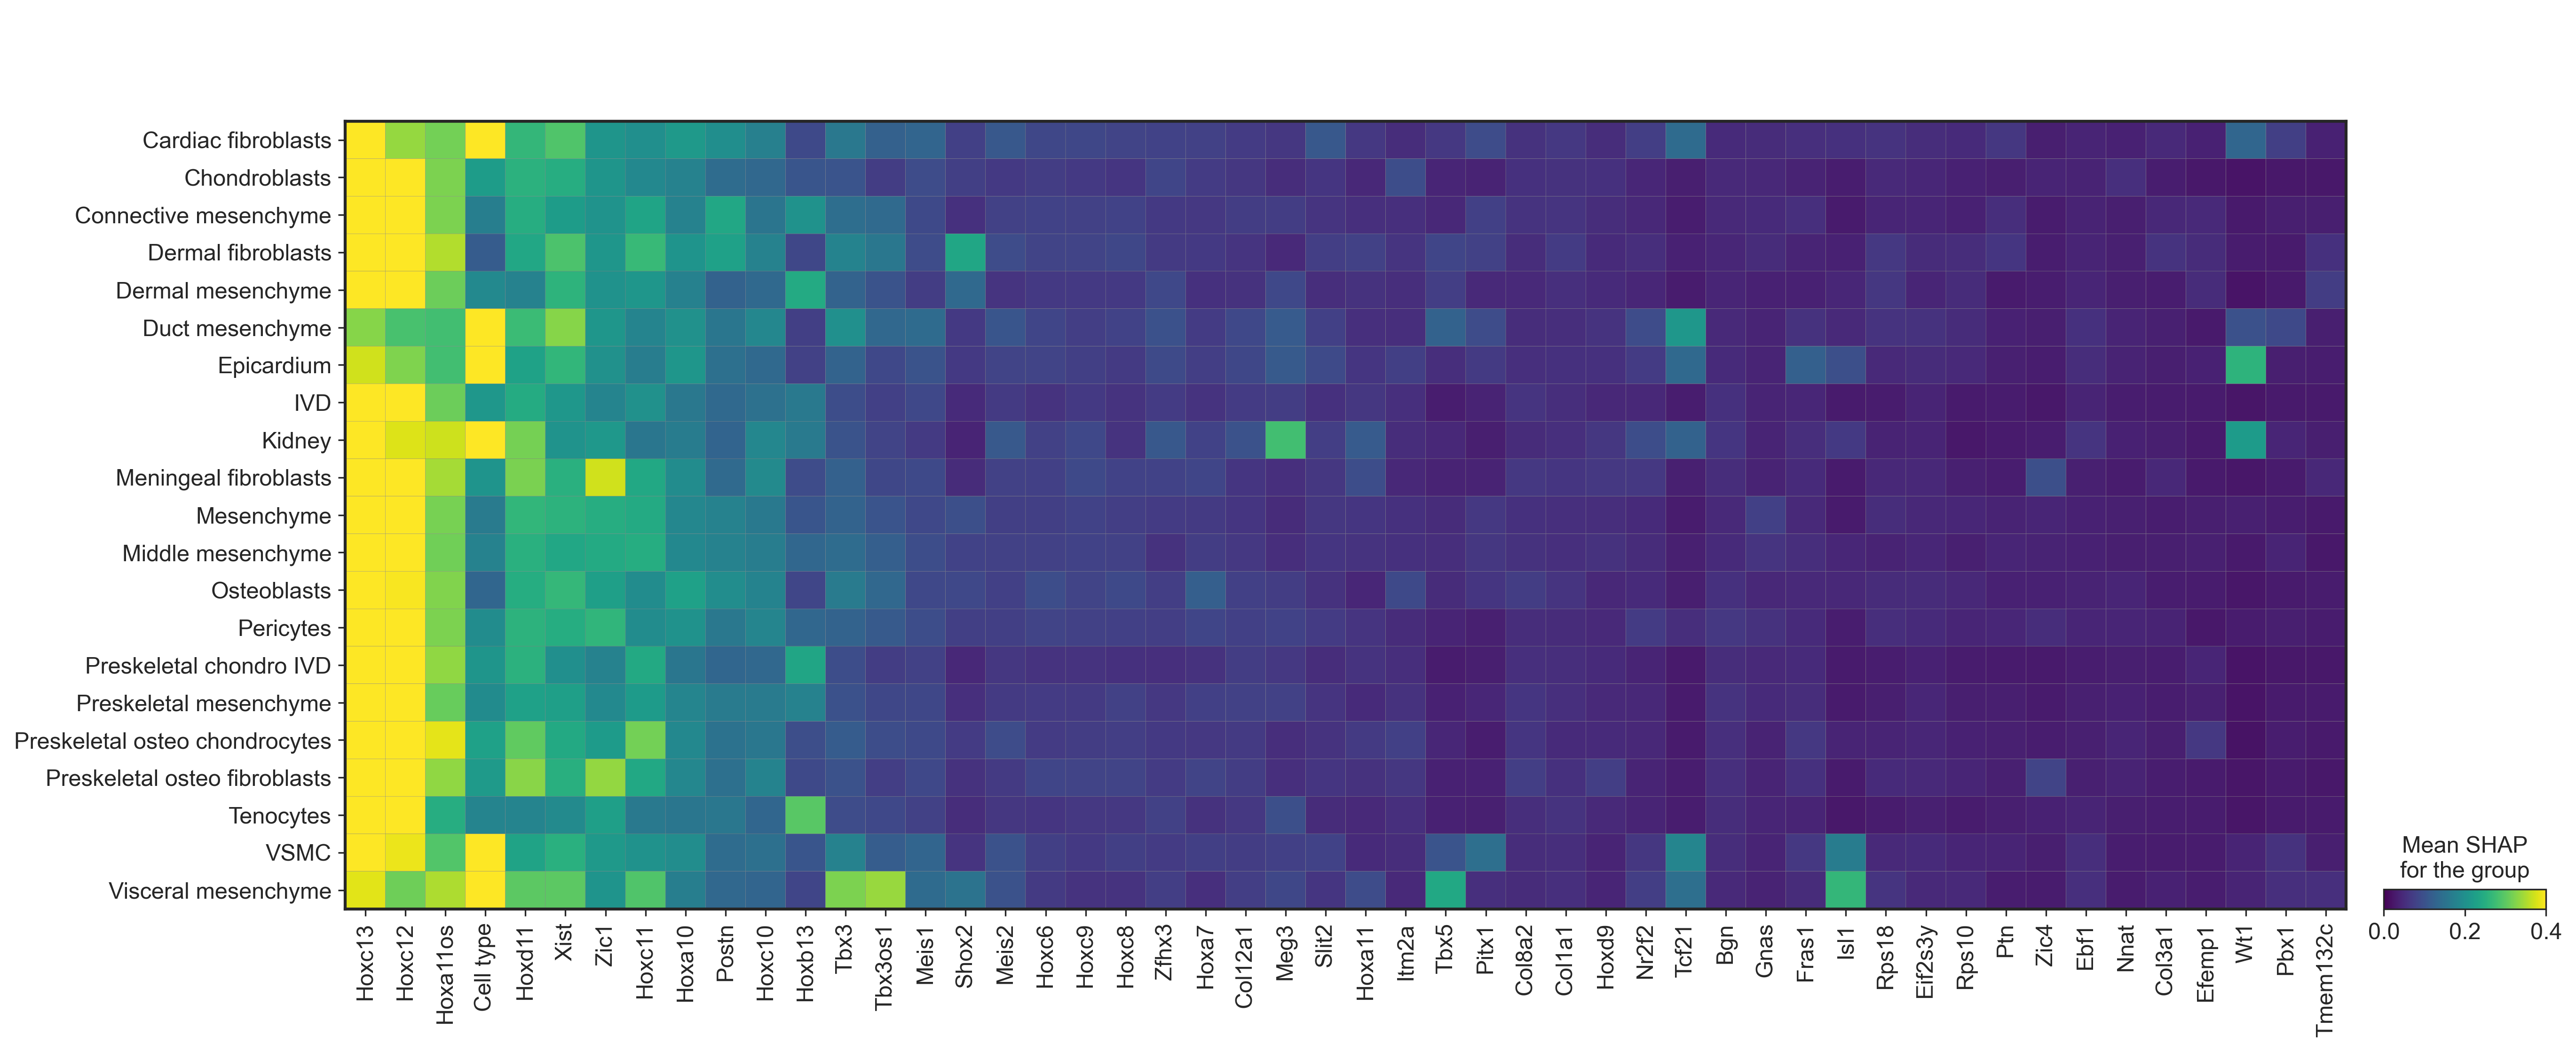

In [22]:
most_important_genes = shapdata.var.sort_values("mean_SHAP").iloc[::-1].head(50).index

sc.pl.matrixplot(
    shapdata,
    var_names=most_important_genes,
    groupby="celltype_l2",
    colorbar_title="Mean SHAP\nfor the group",
    vmin=0,
    vmax=0.4,
    save="global_impact_heatmap.pdf",
)

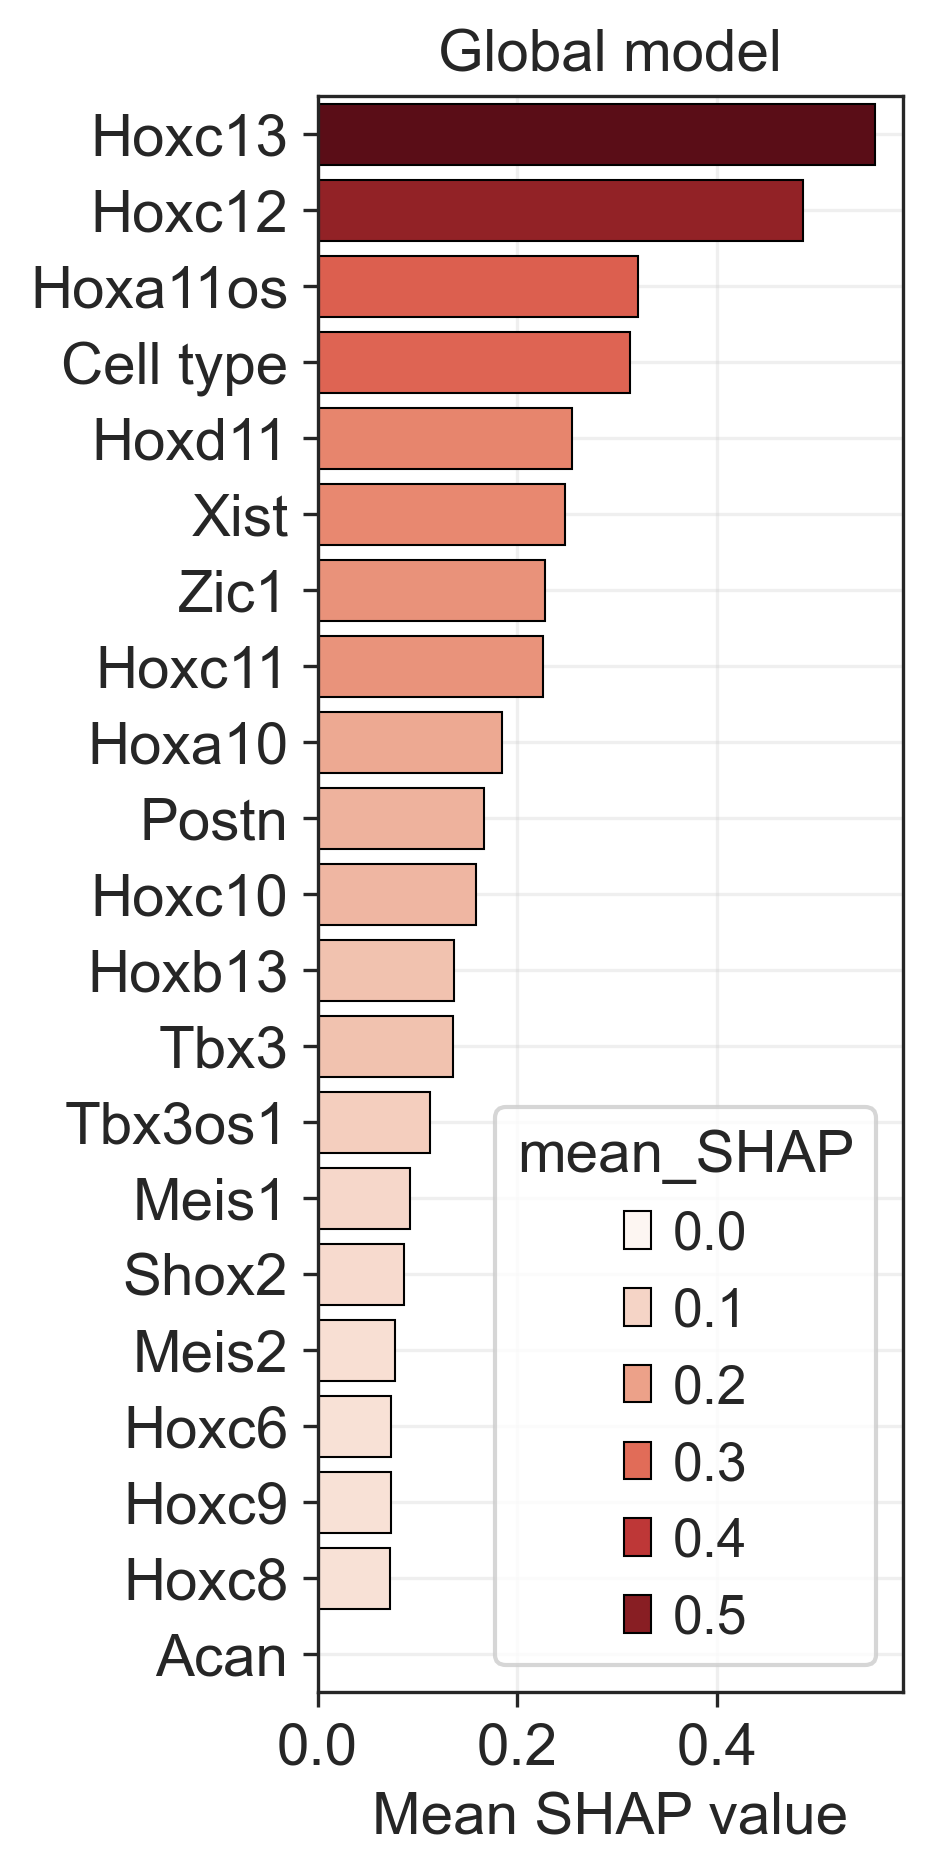

In [370]:
n_genes = 20

genes = list(shapdata.var.mean_SHAP.sort_values(ascending=False)[:n_genes].index) + ["Acan"]
df_plot = pd.DataFrame(shapdata.var.mean_SHAP[genes])
df_plot["gene"] = list(df_plot.index)

fig, ax = plt.subplots(figsize=(2.5, 7))

ax = sns.barplot(
    x="mean_SHAP",
    y="gene",
    hue="mean_SHAP",
    data=df_plot,
    ax=ax,
    width=0.8,
    edgecolor="black",
    linewidth=0.5,
    palette="Reds",
)

ax.set_xlabel("Mean SHAP value")
ax.set_ylabel("")

ax.grid(alpha=0.3)
ax.set_title("Global model")

plt.savefig("figures_CatBoost/SHAP_genes.pdf", bbox_inches="tight")

### Validation of predictions

In [26]:
pdata.obsm["clone2vec_predicted"] = model.predict(
    pd.concat([pdata.to_df(), pdata.obs.celltype_l2], axis=1)
)

clones.obsm["clone2vec_predicted"] = pd.DataFrame(
    pdata.obsm["clone2vec_predicted"]
).groupby(pdata.obs.clone.values).mean().loc[clones.obs_names].values

In [33]:
UMAP = clones.obsm["X_umap"].copy()

sc.pp.neighbors(clones, use_rep="clone2vec_predicted")
sc.tl.umap(clones)
clones.obsm["X_umap_predicted"] = clones.obsm["X_umap"].copy()

sc.pp.neighbors(clones, use_rep="word2vec")
sc.tl.umap(clones)
clones.obsm["X_umap_mesenchyme"] = clones.obsm["X_umap"].copy()

clones.obsm["X_umap"] = UMAP.copy()

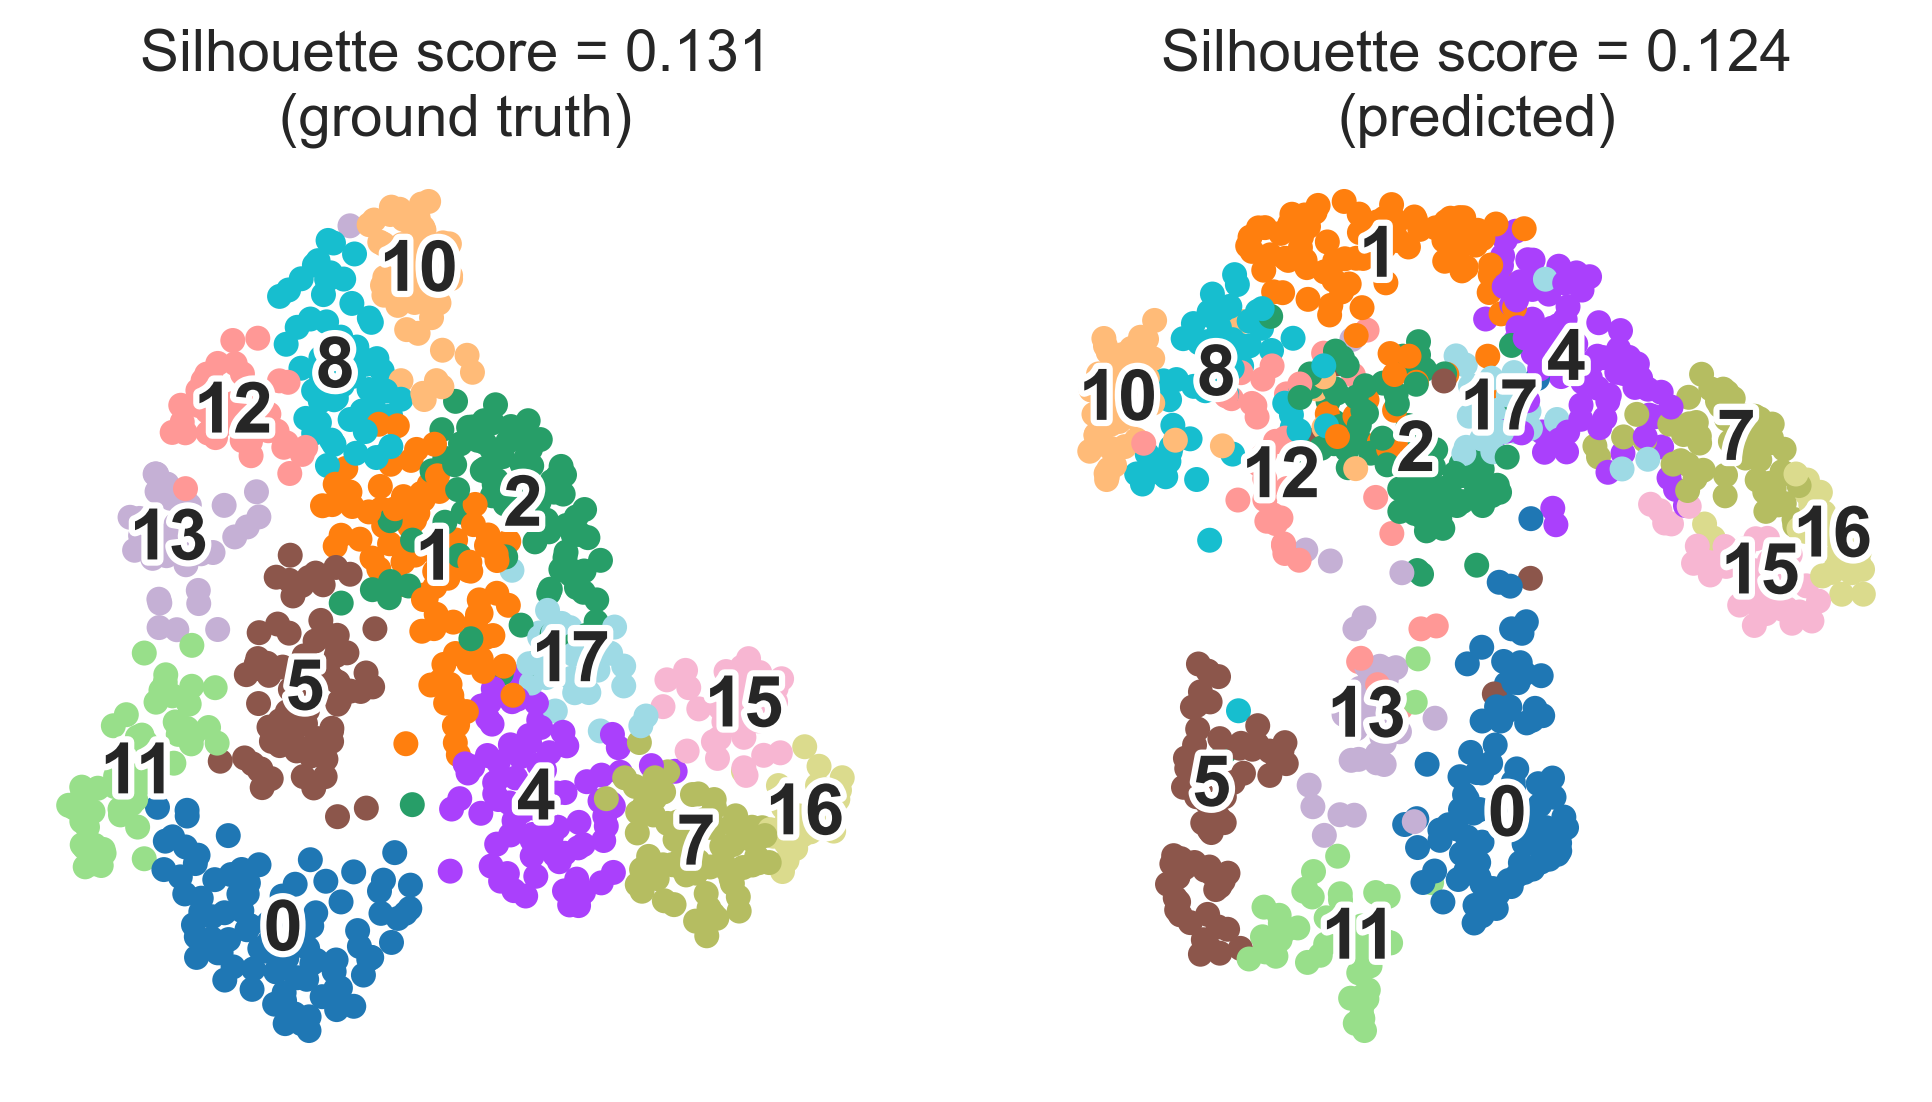

In [284]:
from sklearn.metrics import silhouette_score

ss_truth = np.round(silhouette_score(clones.obsm["word2vec"], clones.obs.leiden_2.values), 3)
ss_predicted = np.round(silhouette_score(clones.obsm["clone2vec_predicted"], clones.obs.leiden_2.values), 3)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.embedding(clones, color="leiden_2", ax=axes[0], title=f"Silhouette score = {str(ss_truth)}\n(ground truth)",
                frameon=False, show=False, legend_loc="on data", legend_fontoutline=3,
                legend_fontsize=17, basis="X_umap_mesenchyme")

sc.pl.embedding(clones, color="leiden_2", ax=axes[1], title=f"Silhouette score = {str(ss_predicted)}\n(predicted)",
                frameon=False, show=False, legend_loc="on data", legend_fontoutline=3,
                legend_fontsize=17, basis="X_umap_predicted")

plt.savefig("figures_CatBoost/SHAP_predictions.pdf", bbox_inches="tight")

## Celltype-specific models

In [264]:
pdata_train.obs[["celltype_l2"]].to_csv("catboost_data/celltypes_train.csv")
pdata_validation.obs[["celltype_l2"]].to_csv("catboost_data/celltypes_validation.csv")

Here is the code that will be used for celltype-specific models:

```python
#!/usr/bin/python3

import pandas as pd
from catboost import Pool, CatBoostRegressor

expression_train = pd.read_csv("GEX_train.csv", index_col=0)
clone2vec_train = pd.read_csv("clone2vec_train.csv", index_col=0)
cts_train = pd.read_csv("celltypes_train.csv", index_col=0)

expression_validation = pd.read_csv("GEX_validation.csv", index_col=0)
clone2vec_validation = pd.read_csv("clone2vec_validation.csv", index_col=0)
cts_validation = pd.read_csv("celltypes_validation.csv", index_col=0)

cts = list(set(cts_train.celltype_l2).intersection(
    cts_validation.celltype_l2
))

for ct in cts:
    X_train = expression_train[cts_train.celltype_l2 == ct].copy()
    y_train = clone2vec_train[cts_train.celltype_l2 == ct].copy()
    train = Pool(data=X_train, label=y_train)
    
    X_validation = expression_validation[cts_validation.celltype_l2 == ct].copy()
    y_validation = clone2vec_validation[cts_validation.celltype_l2 == ct].copy()
    validation = Pool(data=X_validation, label=y_validation)

    model = CatBoostRegressor(
        loss_function="MultiRMSE",
        eval_metric="MultiRMSE",
        num_trees=10000,
        early_stopping_rounds=100,
    )

    model.fit(
        train,
        eval_set=validation,
        use_best_model=True,
    )

    model.save_model(f"models/{ct}.CatBoostRegressor")
```

In [9]:
cts = !ls catboost_models/with_validation/celltype_specific
cts = [i.split(".")[0] for i in cts]

In [10]:
ct_models = {}
ct_SHAP = {}

for ct in cts:
    ct_models[ct] = CatBoostRegressor()
    ct_models[ct].load_model(f"catboost_models/with_validation/celltype_specific/{ct}.CatBoostRegressor")
    print(f"Best iteration for {ct}: {ct_models[ct].get_best_iteration()}")
    
    shap_values_raw = ct_models[ct].get_feature_importance(
        data=Pool(
            data=pdata[pdata.obs.celltype_l2 == ct].to_df(),
            label=pdata[pdata.obs.celltype_l2 == ct].obsm["clone2vec"],
        ),
        type="ShapValues",
    )

    shap_values = pd.DataFrame(
        np.linalg.norm(shap_values_raw, axis=1)[:, :-1],
        columns=list(pdata.var_names),
        index=pdata[pdata.obs.celltype_l2 == ct].obs_names,
    )
    feature_names = np.array(ct_models[ct].feature_names_)
    
    ct_SHAP[ct] = shap_values.mean(axis=0)
    
ct_SHAP = pd.DataFrame(ct_SHAP)
ct_SHAP_backup = ct_SHAP.copy()

Best iteration for Cardiac fibroblasts: 1706
Best iteration for Chondroblasts: 944
Best iteration for Connective mesenchyme: 1116
Best iteration for Dermal fibroblasts: 1122
Best iteration for Dermal mesenchyme: 625
Best iteration for Duct mesenchyme: 1324
Best iteration for Epicardium: 1017
Best iteration for IVD: 912
Best iteration for Kidney: 82
Best iteration for Meningeal fibroblasts: 2038
Best iteration for Mesenchyme: 3152
Best iteration for Middle mesenchyme: 1270
Best iteration for Osteoblasts: 1476
Best iteration for Pericytes: 741
Best iteration for Preskeletal chondro IVD: 904
Best iteration for Preskeletal mesenchyme: 940
Best iteration for Preskeletal osteo chondrocytes: 1145
Best iteration for Preskeletal osteo fibroblasts: 877
Best iteration for Tenocytes: 312
Best iteration for Visceral mesenchyme: 1486
Best iteration for VSMC: 431


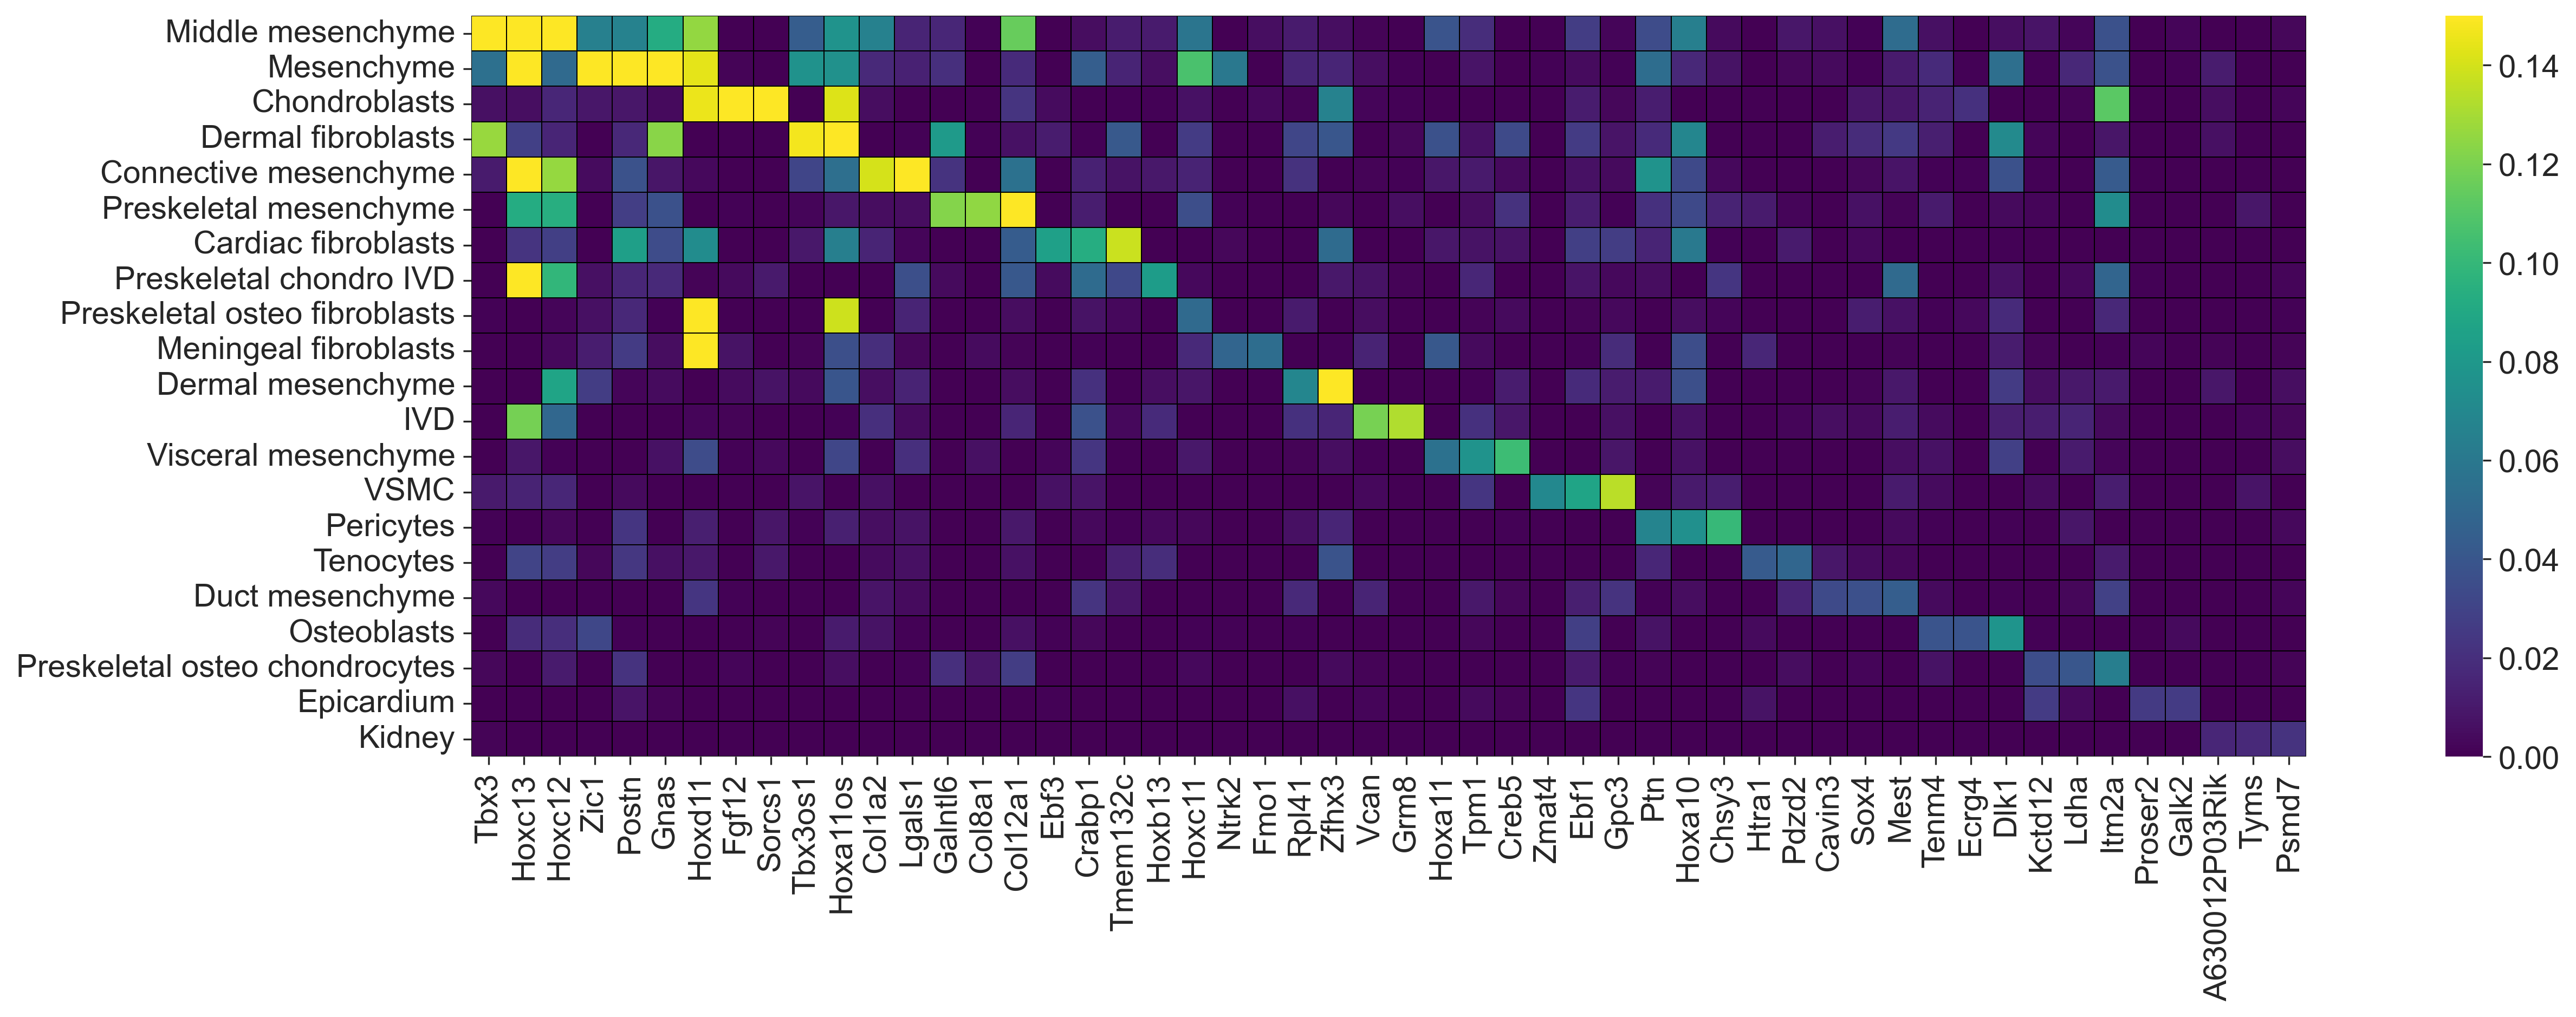

In [15]:
ct_SHAP = ct_SHAP_backup.copy()

n_genes = 3

gene_list = []
for ct in cts:
    gene_list += [i for i in ct_SHAP[ct].sort_values().tail(n_genes).index if i not in gene_list]
ct_order = list(ct_SHAP.loc[gene_list].mean(axis=0).sort_values()[::-1].index)

gene_list = []
for ct in ct_order:
    gene_list += [i for i in ct_SHAP[ct].sort_values().tail(n_genes).index if i not in gene_list]

fig, ax = plt.subplots(figsize=(22, 6))

sns.heatmap(
    ct_SHAP.loc[gene_list].T.loc[ct_order],
    ax=ax,
    cmap="viridis",
    square=True,
    linecolor="k",
    linewidth=0.1,
    vmax=0.15,
)

plt.savefig("figures_CatBoost/SHAP_predictions_ct_specific.pdf", bbox_inches="tight")

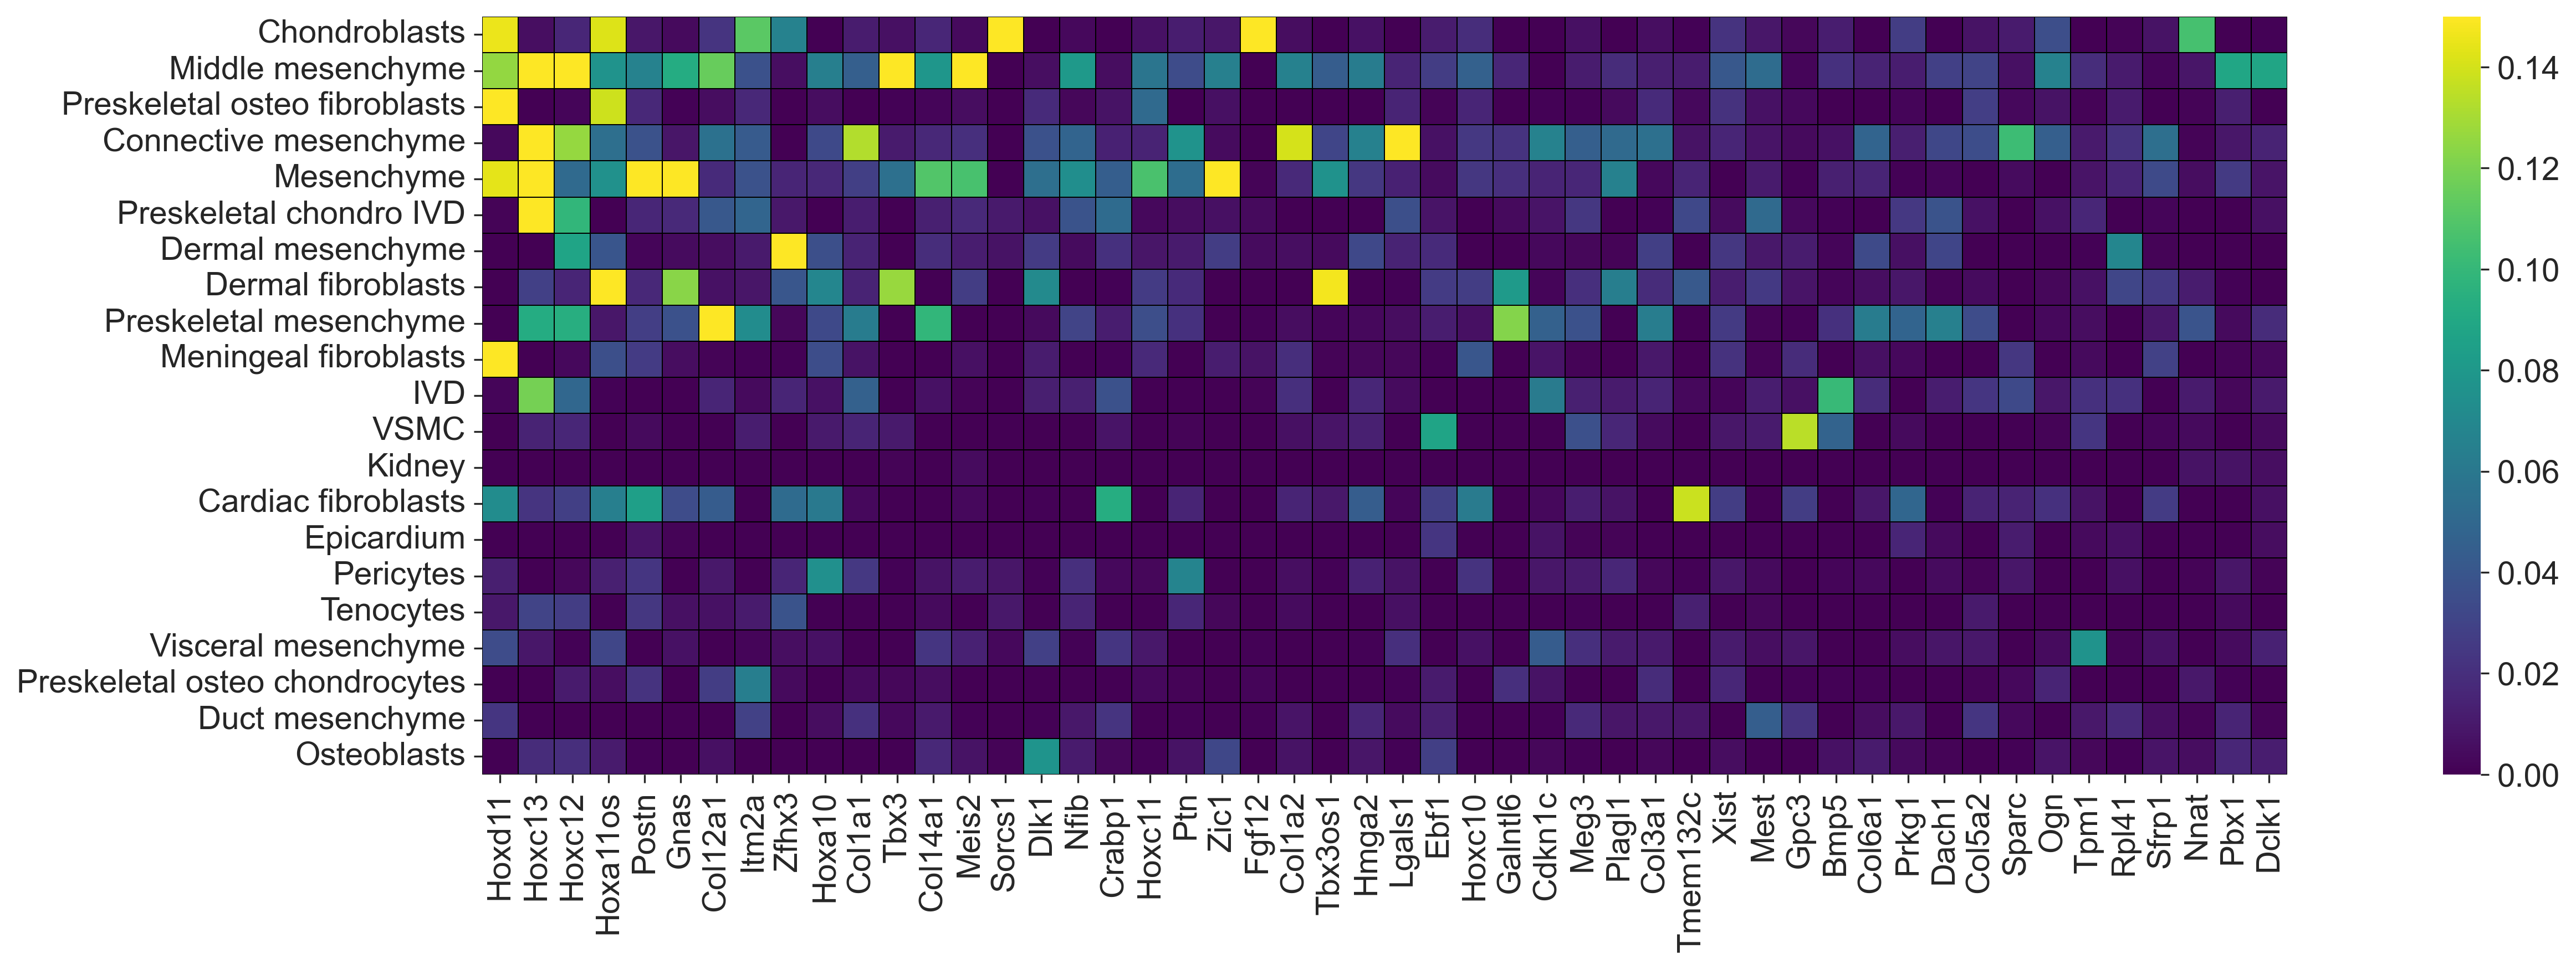

In [349]:
gene_list = list(ct_SHAP.mean(axis=1).sort_values().tail(50).index[::-1])

fig, ax = plt.subplots(figsize=(24, 6))

sns.heatmap(
    ct_SHAP.loc[gene_list].T,
    ax=ax,
    cmap="viridis",
    square=True,
    linecolor="k",
    linewidth=0.1,
    vmax=0.15,
)

plt.savefig("figures_CatBoost/SHAP_predictions_ct_specific_global.pdf", bbox_inches="tight")

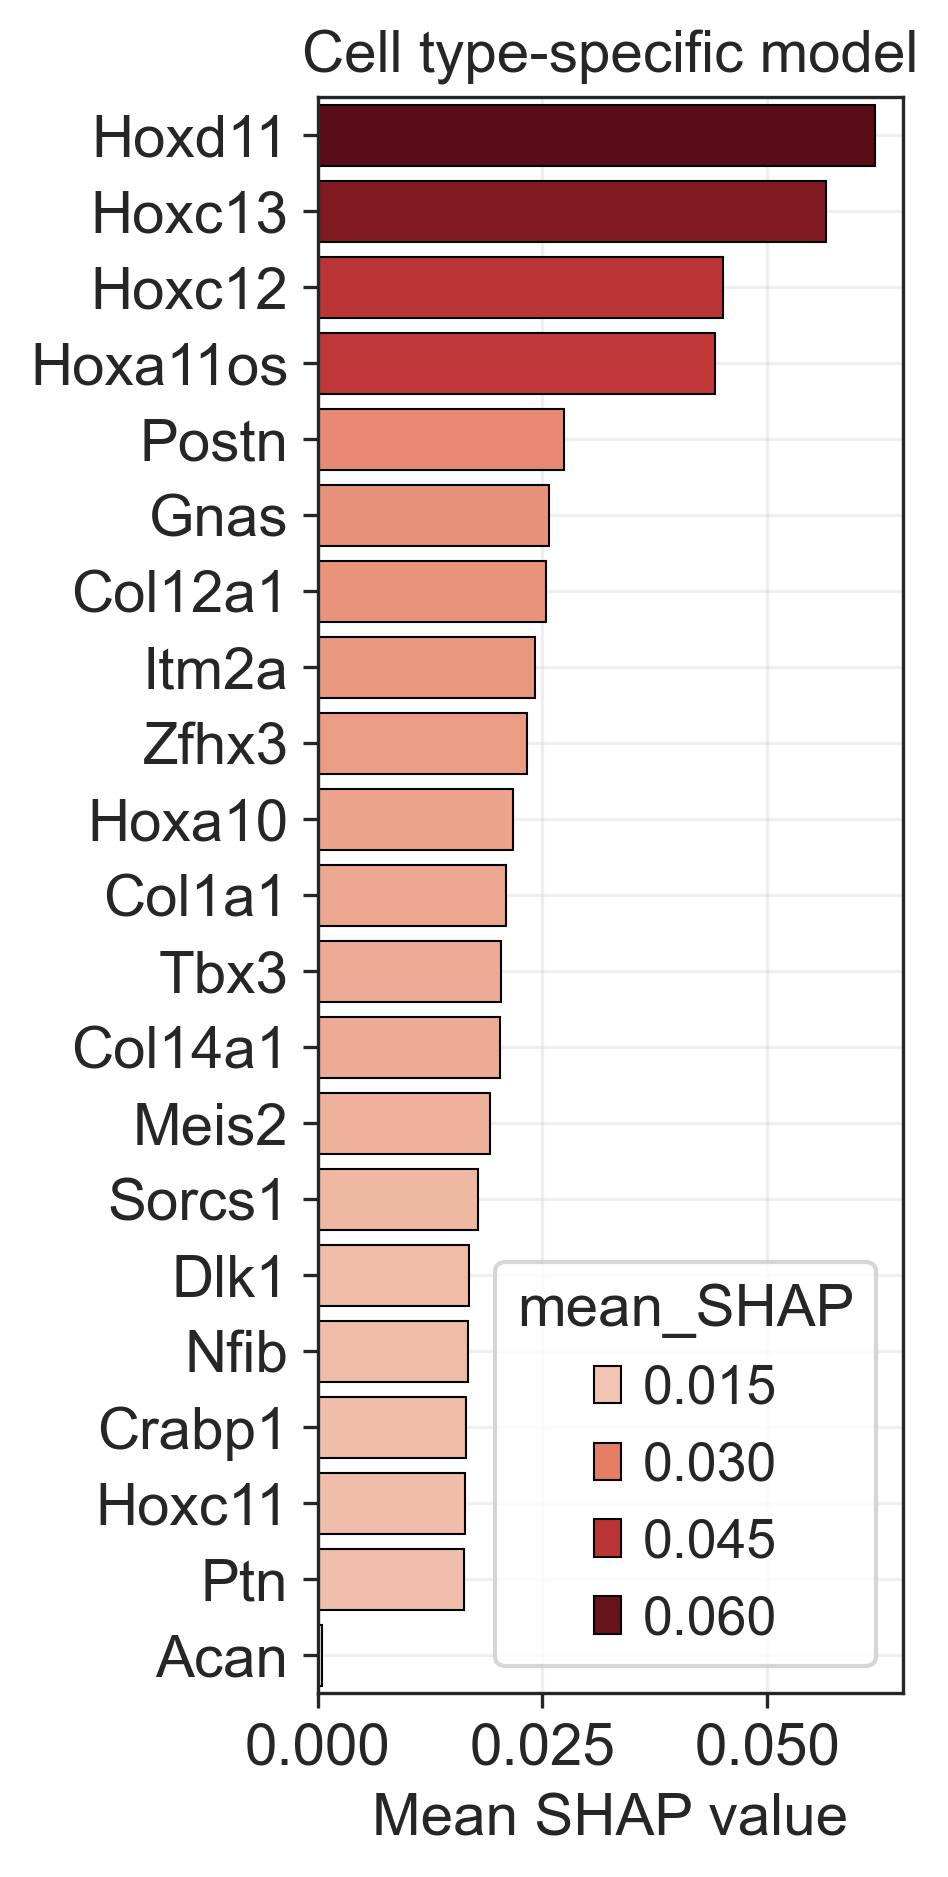

In [369]:
n_genes = 20

genes = list(ct_SHAP.mean(axis=1).sort_values(ascending=False)[:n_genes].index) + ["Acan"]

df_plot = pd.DataFrame(ct_SHAP.mean(axis=1)[genes], columns=["mean_SHAP"])
df_plot["gene"] = list(df_plot.index)

fig, ax = plt.subplots(figsize=(2.5, 7))

ax = sns.barplot(
    x="mean_SHAP",
    y="gene",
    hue="mean_SHAP",
    data=df_plot,
    ax=ax,
    width=0.8,
    edgecolor="black",
    linewidth=0.5,
    palette="Reds",
)

ax.set_xlabel("Mean SHAP value")
ax.set_ylabel("")

ax.grid(alpha=0.3)
ax.set_title("Cell type-specific model")

plt.savefig("figures_CatBoost/SHAP_genes_ct.pdf", bbox_inches="tight")

In [23]:
pd.DataFrame(ct_SHAP[ct][genes])

Mesenchyme
Gnas        0.197327
Postn       0.191301
Zic1        0.175543
Hoxc13      0.164394
Hoxd11      0.143809
Col14a1     0.109045
Hoxc11      0.107116
Meis2       0.106135
Meox2       0.075830
Tbx20       0.075788
Tbx3os1     0.075756
Hoxa11os    0.075538
Nfib        0.073433
Eno1        0.068459
Svil        0.068092
Mecom       0.066373
Plagl1      0.065572
Egfr        0.063235
Ntrk2       0.060126
Slit2       0.056392

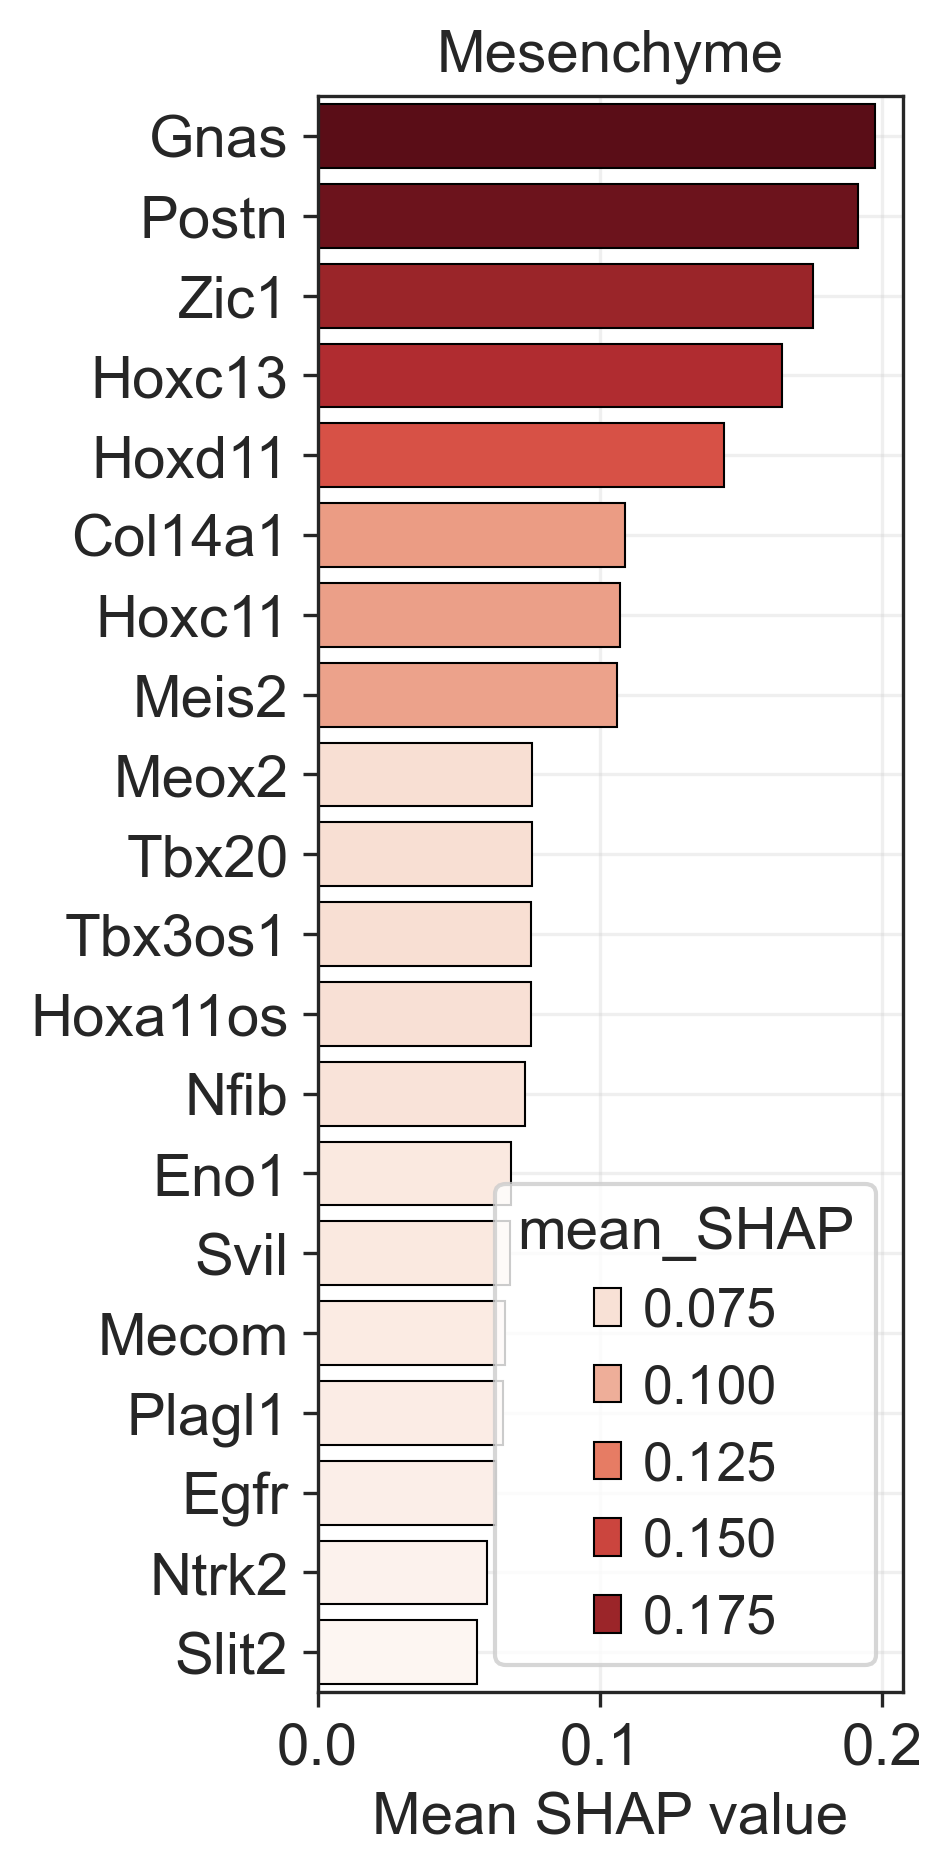

In [78]:
ct = "Mesenchyme"

n_genes = 20

genes = list(ct_SHAP[ct].sort_values(ascending=False)[:n_genes].index)

df_plot = pd.DataFrame(ct_SHAP[ct][genes])
df_plot.columns = ["mean_SHAP"]
df_plot["gene"] = list(df_plot.index)

fig, ax = plt.subplots(figsize=(2.5, 7))

ax = sns.barplot(
    x="mean_SHAP",
    y="gene",
    hue="mean_SHAP",
    data=df_plot,
    ax=ax,
    width=0.8,
    edgecolor="black",
    linewidth=0.5,
    palette="Reds",
)

ax.set_xlabel("Mean SHAP value")
ax.set_ylabel("")

ax.grid(alpha=0.3)
ax.set_title(f"{ct}")

plt.savefig(f"figures_CatBoost/SHAP_genes_{ct}.pdf", bbox_inches="tight")

In [301]:
ct_predictions = pd.DataFrame()

for ct in ct_models:
    ct_predictions = pd.concat([
        pd.DataFrame(
            ct_models[ct].predict(pdata[pdata.obs.celltype_l2 == ct].to_df()),
            index=pdata[pdata.obs.celltype_l2 == ct].obs_names,
        ), ct_predictions
    ])

clones.obsm["clone2vec_ct_prediction"] = ct_predictions.loc[pdata.obs_names].groupby(pdata.obs.clone).mean().loc[clones.obs_names].values

sc.pp.neighbors(clones, use_rep="clone2vec_ct_prediction")
sc.tl.umap(clones)
clones.obsm["X_umap_ct_predicted"] = clones.obsm["X_umap"].copy()

clones.obsm["X_umap"] = UMAP.copy()

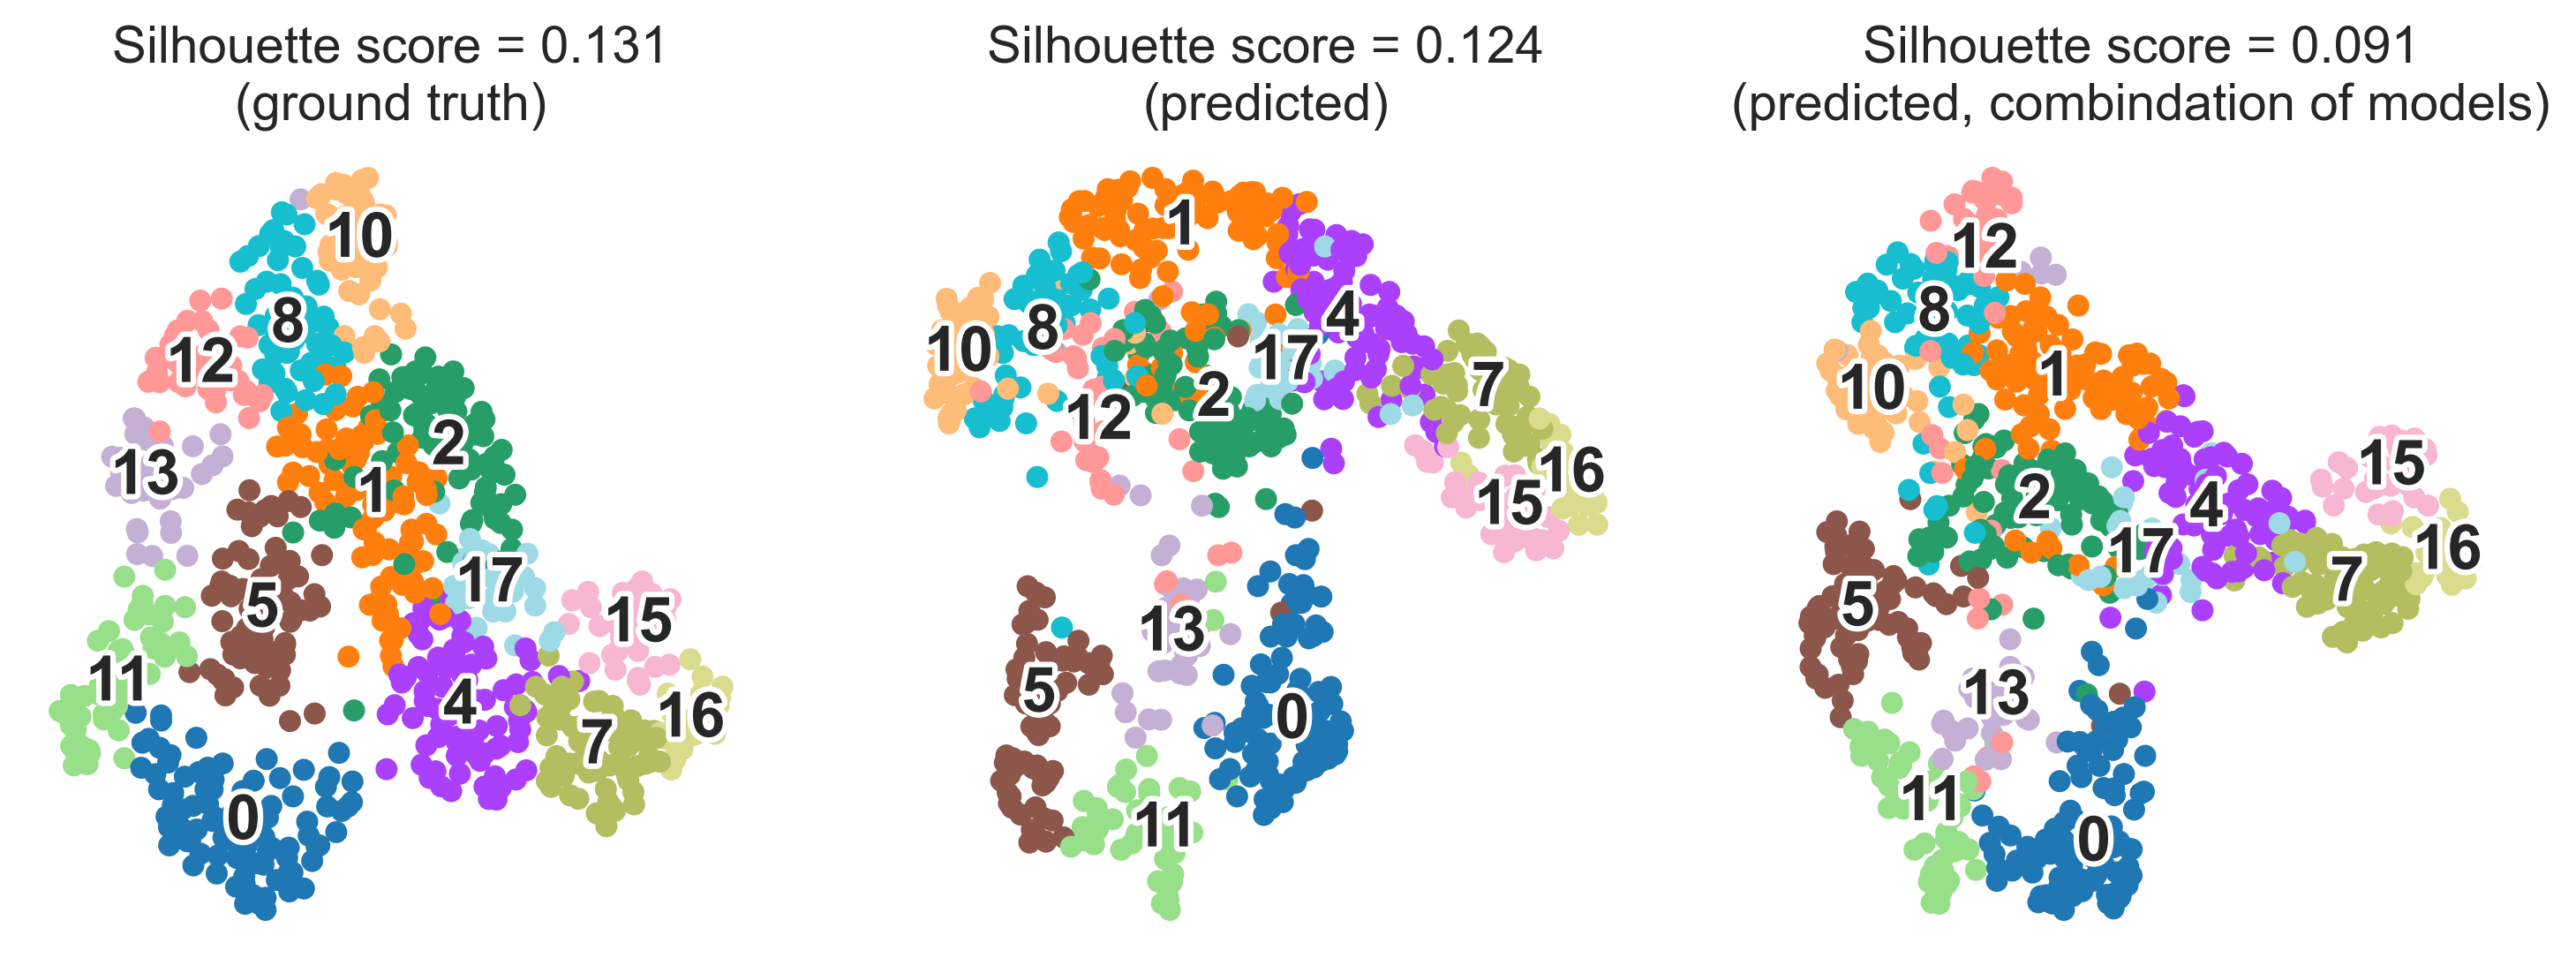

In [304]:
from sklearn.metrics import silhouette_score

ss_truth = np.round(silhouette_score(clones.obsm["word2vec"], clones.obs.leiden_2.values), 3)
ss_predicted = np.round(silhouette_score(clones.obsm["clone2vec_predicted"], clones.obs.leiden_2.values), 3)
ss_ct_predicted = np.round(silhouette_score(clones.obsm["clone2vec_ct_prediction"], clones.obs.leiden_2.values), 3)

fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

sc.pl.embedding(clones, color="leiden_2", ax=axes[0], title=f"Silhouette score = {str(ss_truth)}\n(ground truth)",
                frameon=False, show=False, legend_loc="on data", legend_fontoutline=3,
                legend_fontsize=17, basis="X_umap_mesenchyme")

sc.pl.embedding(clones, color="leiden_2", ax=axes[1], title=f"Silhouette score = {str(ss_predicted)}\n(predicted)",
                frameon=False, show=False, legend_loc="on data", legend_fontoutline=3,
                legend_fontsize=17, basis="X_umap_predicted")

sc.pl.embedding(clones, color="leiden_2", ax=axes[2], title=f"Silhouette score = {str(ss_ct_predicted)}\n(predicted, combindation of models)",
                frameon=False, show=False, legend_loc="on data", legend_fontoutline=3,
                legend_fontsize=17, basis="X_umap_ct_predicted")

plt.savefig("figures_CatBoost/SHAP_predictions.pdf", bbox_inches="tight")

## Fold-change

In [228]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [319]:
ct = "Mesenchyme"
quantile = 0.2
min_cells = 20

df_log2FC_poi = {}
df_FDR_poi = {}

df_log2FC_NB = {}
df_FDR_NB = {}

pdata_subset = pdata[pdata.obs.celltype_l2 == ct]
l = len(pdata_subset)

for gene in genes:
    df_log2FC_poi[gene] = {}
    df_FDR_poi[gene] = {}
    df_log2FC_NB[gene] = {}
    df_FDR_NB[gene] = {}
    
    clone_names_high = pdata_subset.obs_names[
        np.argsort(pdata_subset[:, gene].X.T[0])[-int(l * quantile):]
    ]
    clone_names_low = pdata_subset.obs_names[
        ~pdata_subset.obs_names.isin(clone_names_high)
    ]

    clone_names_high = ["_".join(i.split("_")[:-1]) for i in clone_names_high]
    clone_names_low = ["_".join(i.split("_")[:-1]) for i in clone_names_low]

    clones_subset = clones[clones.obs_names.isin(clone_names_low + clone_names_high)]
    clones_subset.obs["expression_group"] = [
        "high" if i in clone_names_high else "low" for i in clones_subset.obs_names
    ]
    clones_subset = clones_subset[clones_subset.X.sum(axis=1) > min_cells].copy()
    clones_subset = clones_subset[:, list(set(adata.obs.celltype_l2))].copy()

    clones_counts = clones_subset.to_df().astype(int)
    clones_counts.index = list(clones_counts.index)
    clones_counts.columns = list(clones_counts.columns)
    clones_counts["log_total"] = np.log(clones_counts.sum(axis=1))
    metadata = clones_subset.obs[["expression_group"]]
    
    sm_df = pd.concat([clones_counts, metadata], axis=1)
    sm_df["expression_group"] = sm_df["expression_group"].astype("category")
    sm_df["expression_group"] = sm_df["expression_group"].cat.reorder_categories(["low", "high"])
    sm_df.columns = [i.replace(" ", "_") for i in sm_df]
    
    for ct in clones_subset.var_names:
        ct = ct.replace(" ", "_")
        try:
            poisson_model = smf.poisson(f"{ct} ~ C(expression_group)", data=sm_df, offset=clones_counts["log_total"]).fit()
            p_poi = poisson_model.pvalues["C(expression_group)[T.high]"]
            log2FC_poi = poisson_model.params["C(expression_group)[T.high]"]

            nb_model = smf.negativebinomial(f"{ct} ~ C(expression_group)", data=sm_df, offset=clones_counts["log_total"]).fit()
            p_nb = nb_model.pvalues["C(expression_group)[T.high]"]
            log2FC_nb = nb_model.params["C(expression_group)[T.high]"]
            
            ct = ct.replace("_", " ")
            df_log2FC_poi[gene][ct] = log2FC_poi
            df_FDR_poi[gene][ct] = p_poi
            df_log2FC_NB[gene][ct] = log2FC_nb
            df_FDR_NB[gene][ct] = p_nb
        except:
            ct = ct.replace("_", " ")
            df_log2FC_poi[gene][ct] = None
            df_FDR_poi[gene][ct] = None
            df_log2FC_NB[gene][ct] = None
            df_FDR_NB[gene][ct] = None

Optimization terminated successfully.
         Current function value: 3.922153
         Iterations 8
Optimization terminated successfully.
         Current function value: 1.984027
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 4.013615
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.616399
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.485016
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.388005
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 2.653653
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.842

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.933613
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.375787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375566
         Iterations: 2
         Function evaluations: 46
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 1.763478
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.286625
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 2.432278
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.462994
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimiz

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 2.594229
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.326234
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 4.396447
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.054295
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 4.075312
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.623869
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.346463
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.339

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.242403
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 2.434278
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.453362
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 6.896643
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.109490
         Iterations: 14
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 3.121039
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.976522
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 1.388381
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 2.701826
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.845215
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.060171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.894453
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 3.270579
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.900527
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.810937
         Iterations: 15
         Function evaluations: 126
         Gradient evaluations: 126
Optimization terminated successfully.
         Current function value: 3.512677
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.834061
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.903060
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.159885
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.139037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.946535
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Opti

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.379756
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.944232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492006
         Iterations: 16
         Function evaluations: 37
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: 1.206656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.810162
         Iterations: 15
         Function evaluations: 125
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 3.543958
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.840720
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optim

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.469571
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 6.722495
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.113984
         Iterations: 20
         Function evaluations: 28
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 2.901831
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.937549
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 2.610922
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.327221
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 2.965995
         Iterations 4
Optimization terminated successfully.
         Current function value: 2.171968
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.139648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.946171
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.370967
         Iterations 7
         Current function value: nan
         Iterations: 2
         Function evaluations: 112
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 1.750446
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.285180
         Iterations: 15
         Funct

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 4.036970
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.038808
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 4.080511
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.621101
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.393922
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.374549
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 2.422988
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.788

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.082718
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 2.843498
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.933425
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 2.584901
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.318878
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 3.062250
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.955758
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 2.143471
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.078979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.932976
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.356269
         Iterations 7
         Current function value: nan
         Iterations: 2
         Function evaluations: 123
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: 1.695697
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.276494
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         C

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.496081
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.378692
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.960824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494161
         Iterations: 17
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 1.211961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.811435
         Iterations: 12
         Function evaluations: 123
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: 3.542876
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.8

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.809995
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 3.532692
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.839596
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 2.957000
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.173674
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.098231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.934267
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimiz

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 2.330590
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 3.655812
         Iterations 8
Optimization terminated successfully.
         Current function value: 1.972242
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 3.989075
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.628626
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.499931
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.387300
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.286030
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 2.509814
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.470915
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 6.653890
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.111108
         Iterations: 15
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 2.749921
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.927567
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/li

         Current function value: nan
         Iterations: 2
         Function evaluations: 113
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 1.183561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.801709
         Iterations: 14
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 3.074113
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.705956
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 2.644438
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.125467
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Cur

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.719472
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.276990
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 2.241657
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.432125
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 6.097079
         Iterations 8
Optimization terminated successfully.
         Current function value: 1.088735
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 2.842605
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.946

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.975217
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 2.598643
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.322678
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 4.009840
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.040695
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 3.971468
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.623271
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.191396
         Iterations: 19
         Function evaluations: 143
         Gradient evaluations: 143
Optimization terminated successfully.
         Current function value: 1.750134
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.280252
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 2.511434
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.468749
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 7.007182
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.111962
         Iterations: 18
         Function evaluations: 26
         Gradient evaluations: 26
Opti

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.810794
         Iterations: 13
         Function evaluations: 124
         Gradient evaluations: 124
Optimization terminated successfully.
         Current function value: 3.524476
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.834547
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 2.882120
         Iterations 5
Optimization terminated successfully.
         Current function value: 2.154778
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.124726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.940499
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optim

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.283492
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 2.485234
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.469935
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 6.967635
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.114263
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 3.098703
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.973065
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimi

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 1.126997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.944000
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.371502
         Iterations 6
         Current function value: 0.193317
         Iterations: 19
         Function evaluations: 145
         Gradient evaluations: 134
Optimization terminated successfully.
         Current function value: 1.728725
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.271133
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 2.512180
         Iterations 5
Optimization terminated successfully.
         Current function value: 1.468714
         Iterations: 13
        

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [320]:
df_log2FC_poi = pd.DataFrame(df_log2FC_poi)
df_FDR_poi = pd.DataFrame(df_FDR_poi)

In [322]:
from statsmodels.stats.multitest import multipletests

df_FDR_poi = pd.DataFrame(
    multipletests(df_FDR_poi.values.flatten(), method="fdr_bh")[1].reshape(df_FDR_poi.shape),
    index=df_log2FC_poi.index,
    columns=df_log2FC_poi.columns,
)
df_log2FC_poi[df_log2FC_poi > 0.01] = 0

<Axes: >

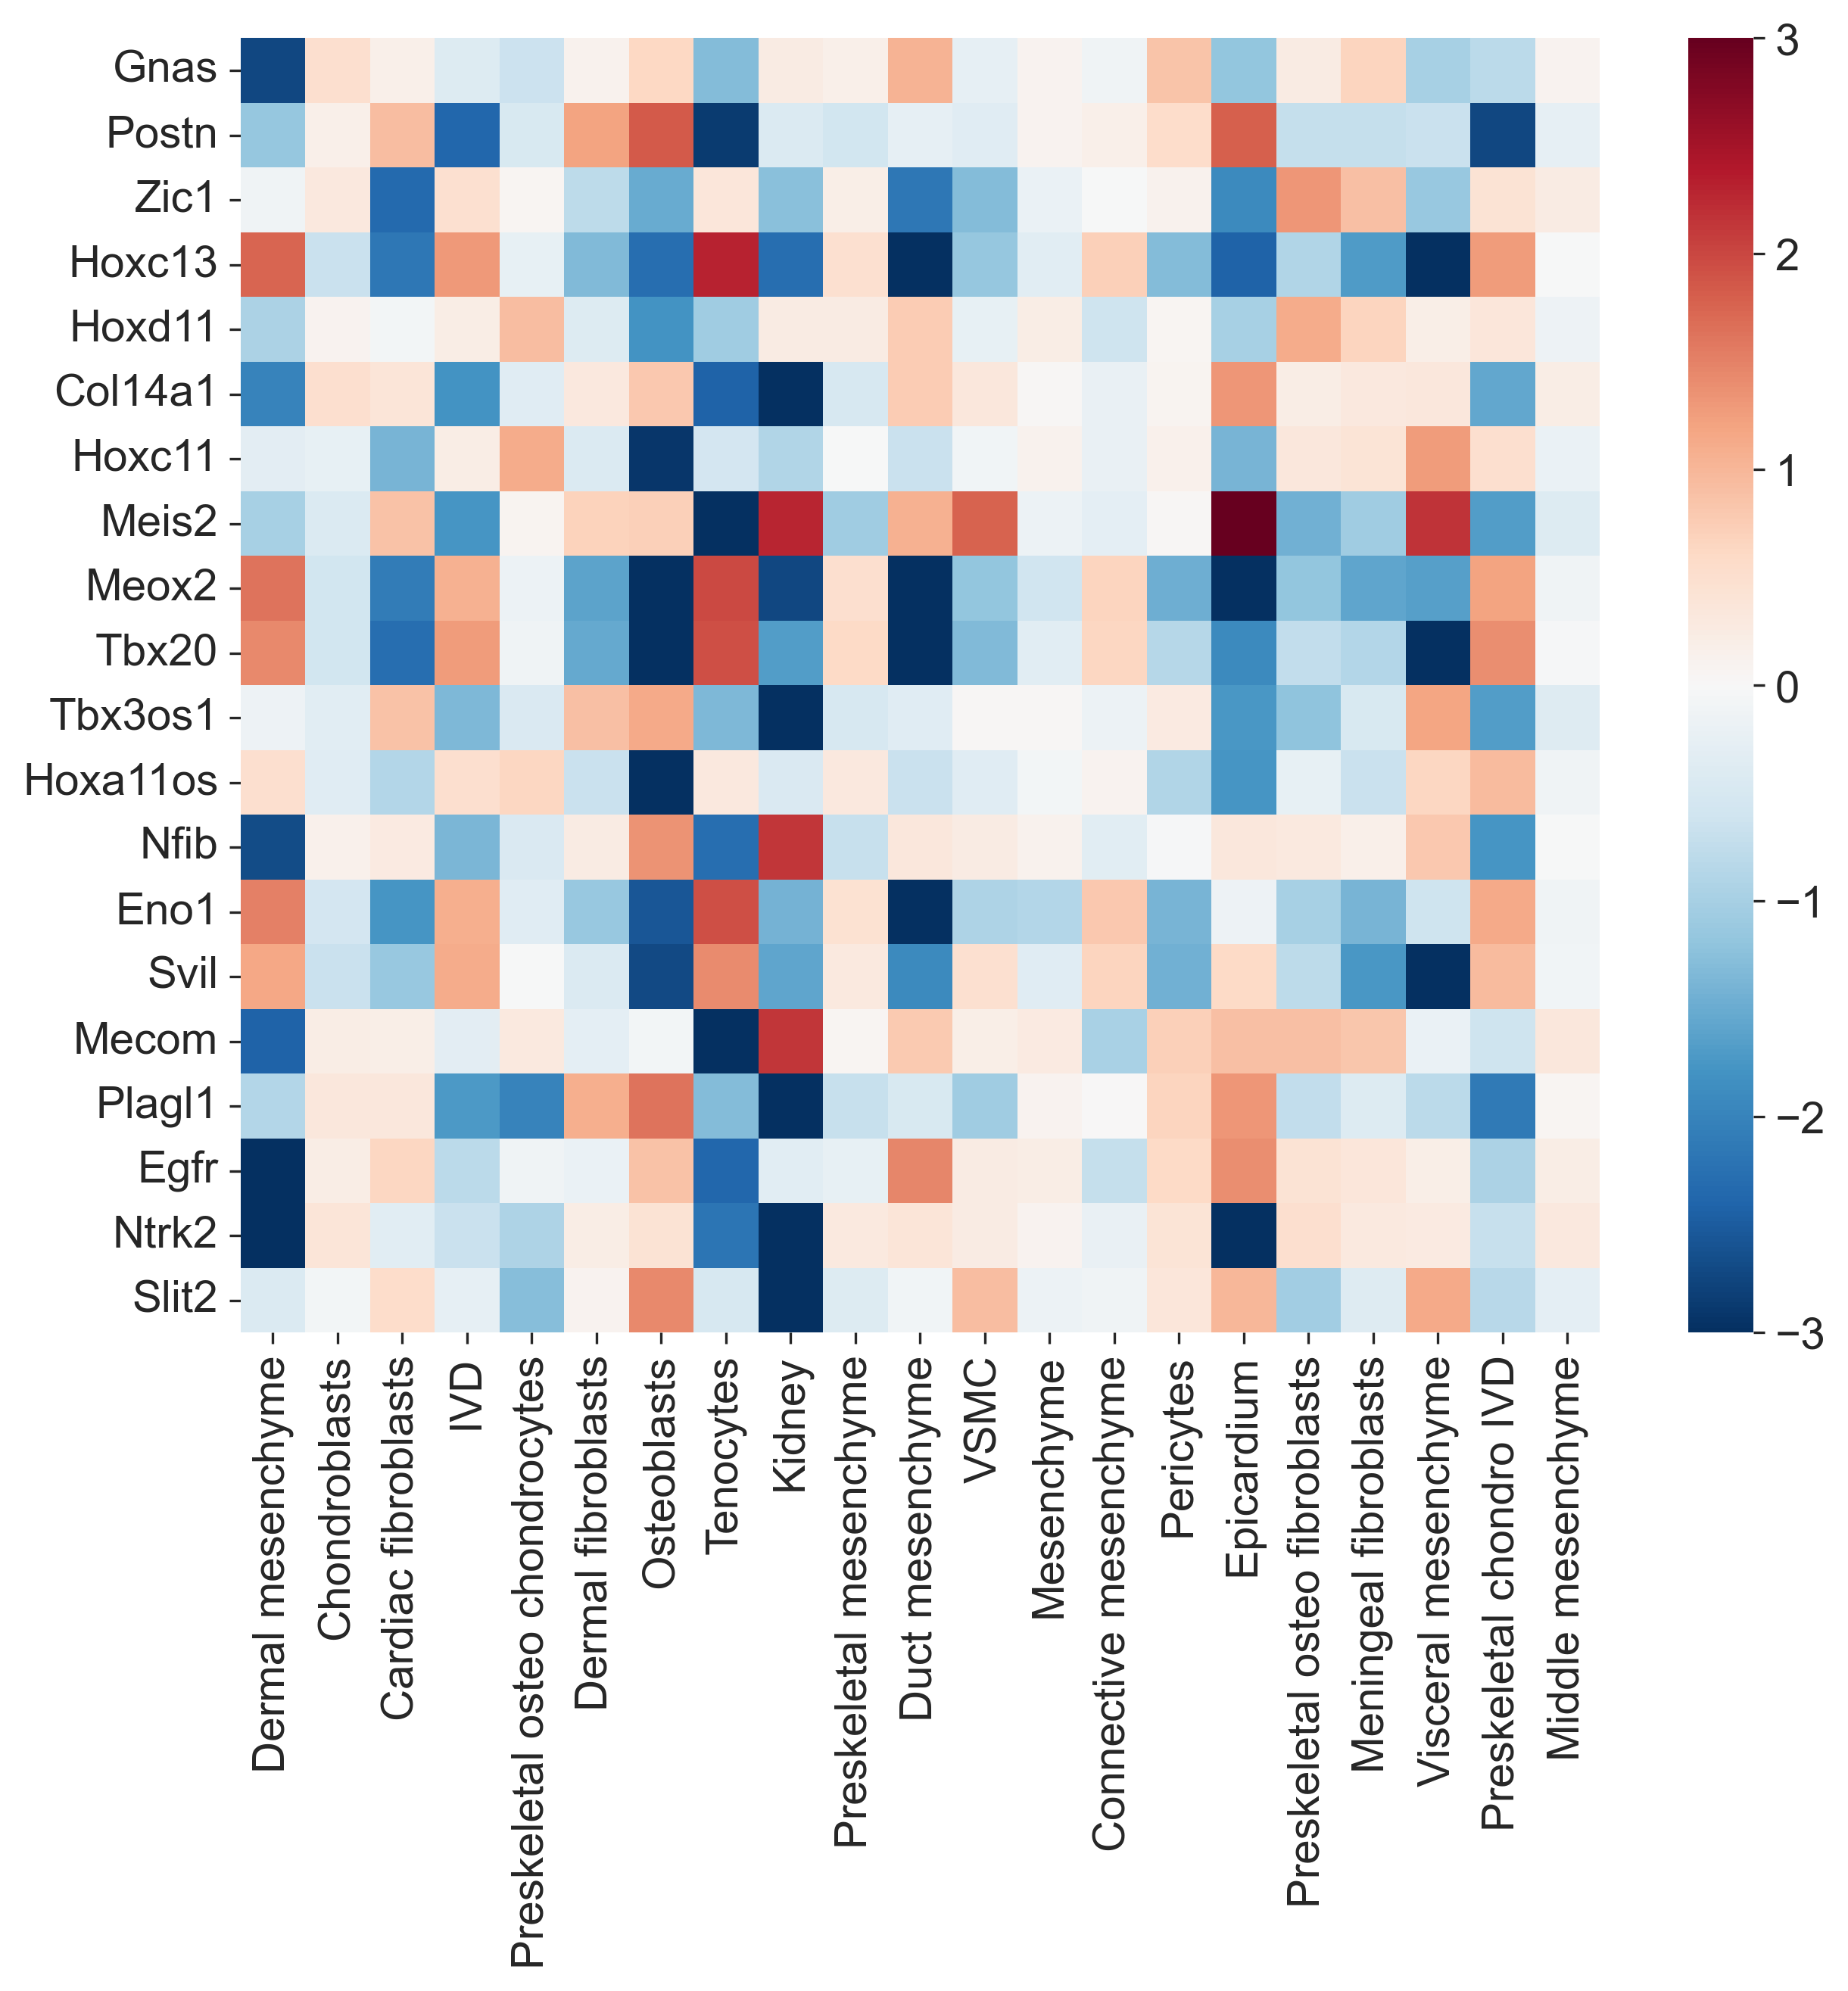

In [324]:
fig, ax = plt.subplots(figsize=(10, 7.5))

sns.heatmap(pd.DataFrame(df_log2FC_NB).T, vmin=-3, vmax=3, cmap="RdBu_r", square=True)

In [223]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sm_df = pd.concat([clones_counts, metadata], axis=1)
sm_df["expression_group"] = sm_df["expression_group"].astype("category")
sm_df["expression_group"] = sm_df["expression_group"].cat.reorder_categories(["low", "high"])

poisson_model = smf.poisson("Chondroblasts ~ C(expression_group)", data=sm_df).fit()
p = poisson_model.pvalues["C(expression_group)[T.high]"]

Optimization terminated successfully.
         Current function value: 4.480194
         Iterations 4


In [249]:
df_FC_old = df_FC.copy()
df_FDR_old = df_FDR.copy()

In [ ]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    ref_level=['disease', 'normal'],
    refit_cooks=True,
    inference=inference,
)

In [187]:
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=clones_counts,
    metadata=metadata,
    design_factors="expression_group",
    ref_level=["expression_group", "low"], 
    inference=inference,
    refit_cooks=True,
)
dds.deseq2()

Fitting size factors...
Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.10 seconds.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting dispersions...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting dispersions...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.


KeyboardInterrupt



In [ ]:
dds.varm[""]